In [4]:
import pandas as pd 
import numpy as np
import warnings
from IPython.display import display
from ast import literal_eval
warnings.filterwarnings('ignore')
# import matplotlib.pyplot as plt
import scipy.sparse as sp

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

In [41]:
def read_file(path,limiter=','):
    df = pd.read_csv(path,delimiter=limiter)
    return df

def get_list(data):
    if isinstance(data, list):
        names = [col['name'] for col in data]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

def get_director(data):
    for d in data:
        if d['job']=='Director':
            return d['name']
    return np.nan

def clean_data(data):
    if isinstance(data,list):
        return data[:3]
    
def combination(x):
    return ','.join(x['Cast']) + ',' + x['Director'] + ','+','.join(x['Genres'])+','+x['original_title']

def transformer(data):
    count = CountVectorizer(stop_words='english')
    cvt_matrix = count.fit_transform(data['Combined'])
    
    tfidf = TfidfVectorizer(stop_words='english')
    tf_matrix=tfidf.fit_transform(data['overview'])
    
    combo = sp.hstack([cvt_matrix,tf_matrix],format='csr')
    
    similarity = cosine_similarity(combo,combo)
#     similarity = cosine_similarity(cvt_matrix,cvt_matrix)
    return similarity

def recommendations(title,data,model):
    indices = pd.Series(data.index, index = data['original_title'])
    idx = indices[title]
    sim = list(enumerate(model[idx]))
#     print(sim)
    sim = sorted(sim, key=lambda x: x[1], reverse=True)
    sim = sim[1:6]
    movie_indices = [i[0] for i in sim]
    return data['original_title'].iloc[movie_indices]

In [6]:
credits = read_file('/Users/saad/Desktop/Projects/Movie Recommendation System/Dataset/Hollywood Movies/tmdb_5000_credits.csv')
display(credits.head())
display(credits.describe())
display(credits.info())

movie_id                                     title  \
0     19995                                    Avatar   
1       285  Pirates of the Caribbean: At World's End   
2    206647                                   Spectre   
3     49026                     The Dark Knight Rises   
4     49529                               John Carter   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   
1  [{"cast_id": 4, "character": "Captain Jack Spa...   
2  [{"cast_id": 1, "character": "James Bond", "cr...   
3  [{"cast_id": 2, "character": "Bruce Wayne / Ba...   
4  [{"cast_id": 5, "character": "John Carter", "c...   

                                                crew  
0  [{"credit_id": "52fe48009251416c750aca23", "de...  
1  [{"credit_id": "52fe4232c3a36847f800b579", "de...  
2  [{"credit_id": "54805967c3a36829b5002c41", "de...  
3  [{"credit_id": "52fe4781c3a36847f81398c3", "de...  
4  [{"credit_id": "52fe479ac3a36847f813eaa3", "de...

movie_id
count    4803.000000
mean    57165.484281
std     88694.614033
min         5.000000
25%      9014.500000
50%     14629.000000
75%     58610.500000
max    459488.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4803 non-null   int64 
 1   title     4803 non-null   object
 2   cast      4803 non-null   object
 3   crew      4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB


None

The above analysis shows there are no missing values and the rows of the dataset are 4803

In [7]:
movies = read_file('/Users/saad/Desktop/Projects/Movie Recommendation System/Dataset/Hollywood Movies/tmdb_5000_movies.csv')
display(movies.head())
display(movies.describe())
display(movies.info())

budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
2  [{"id": 470, "name": "spy"}, {"id": 818, "name...                en   
3  [{"id": 849, "name": "dc comics"}, {"id": 853,...                en   
4  [{"id": 818, "name": "based on novel"}, {"id":...                en   

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                            overview  popularity  \
0  In the 22nd century, a paraplegic Marine is di...  150.437577   
1  Captain Barbossa, long believed to be dead, ha...  139.082615   
2  A cryptic message from Bond’s past sends him o...  107.376788   
3  Following the death of District Attorney Harve...  112.312950   
4  John Carter is a war-weary, former military ca...   43.926995   

                                production_companies  \
0  [{"name": "Ingenious Film Partners", "id": 289...   
1  [{"name": "Walt Disney Pictures", "id": 2}, {"...   
2  [{"name": "Columbia Pictures", "id": 5}, {"nam...   
3  [{"name": "Legendary Pictures", "id": 923}, {"...   
4        [{"name": "Walt Disney Pictures", "id": 2}]   

                                production_countries release_date     revenue  \
0  [{"iso_3166_1": "US", "name": "United States o...   2009-12-10  2787965087   
1  [{"iso_3166_1": "US", "name": "United States o...   2007-05-19   961000000   
2  [{"iso_3166_1": "GB", "name": "United Kingdom"...   2015-10-26   880674609   
3  [{"iso_3166_1": "US", "name": "United States o...   2012-07-16  1084939099   
4  [{"iso_3166_1": "US", "name": "United States o...   2012-03-07   284139100   

   runtime                                   spoken_languages    status  \
0    162.0  [{"iso_639_1": "en", "name": "English"}, {"iso...  Released   
1    169.0           [{"iso_639_1": "en", "name": "English"}]  Released   
2    148.0  [{"iso_639_1": "fr", "name": "Fran\u00e7ais"},...  Released   
3    165.0           [{"iso_639_1": "en", "name": "English"}]  Released   
4    132.0           [{"iso_639_1": "en", "name": "English"}]  Released   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   
2                           A Plan No One Escapes   
3                                 The Legend Ends   
4            Lost in our world, found in another.   

                                      title  vote_average  vote_count  
0                                    Avatar           7.2       11800  
1  Pirates of the Caribbean: At World's End           6.9        4500  
2                                   Spectre           6.3        4466  
3                     The Dark Knight Rises           7.6        9106  
4                               John Carter           6.1        2124

budget             id   popularity       revenue      runtime  \
count  4.803000e+03    4803.000000  4803.000000  4.803000e+03  4801.000000   
mean   2.904504e+07   57165.484281    21.492301  8.226064e+07   106.875859   
std    4.072239e+07   88694.614033    31.816650  1.628571e+08    22.611935   
min    0.000000e+00       5.000000     0.000000  0.000000e+00     0.000000   
25%    7.900000e+05    9014.500000     4.668070  0.000000e+00    94.000000   
50%    1.500000e+07   14629.000000    12.921594  1.917000e+07   103.000000   
75%    4.000000e+07   58610.500000    28.313505  9.291719e+07   118.000000   
max    3.800000e+08  459488.000000   875.581305  2.787965e+09   338.000000   

       vote_average    vote_count  
count   4803.000000   4803.000000  
mean       6.092172    690.217989  
std        1.194612   1234.585891  
min        0.000000      0.000000  
25%        5.600000     54.000000  
50%        6.200000    235.000000  
75%        6.800000    737.000000  
max       10.000000  13752.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

None

The above analysis shows that there are missing values in the id and the tagline. Since we have no information for those, only the one whihc have no missing values will be considered.

In [8]:
credits.rename(columns={"movie_id": "id"},inplace=True)
credits.columns

Index(['id', 'title', 'cast', 'crew'], dtype='object')

In [9]:
meta = movies.merge(credits,on='id',how='left')
meta.head()

budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
2  [{"id": 470, "name": "spy"}, {"id": 818, "name...                en   
3  [{"id": 849, "name": "dc comics"}, {"id": 853,...                en   
4  [{"id": 818, "name": "based on novel"}, {"id":...                en   

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                            overview  popularity  \
0  In the 22nd century, a paraplegic Marine is di...  150.437577   
1  Captain Barbossa, long believed to be dead, ha...  139.082615   
2  A cryptic message from Bond’s past sends him o...  107.376788   
3  Following the death of District Attorney Harve...  112.312950   
4  John Carter is a war-weary, former military ca...   43.926995   

                                production_companies  ... runtime  \
0  [{"name": "Ingenious Film Partners", "id": 289...  ...   162.0   
1  [{"name": "Walt Disney Pictures", "id": 2}, {"...  ...   169.0   
2  [{"name": "Columbia Pictures", "id": 5}, {"nam...  ...   148.0   
3  [{"name": "Legendary Pictures", "id": 923}, {"...  ...   165.0   
4        [{"name": "Walt Disney Pictures", "id": 2}]  ...   132.0   

                                    spoken_languages    status  \
0  [{"iso_639_1": "en", "name": "English"}, {"iso...  Released   
1           [{"iso_639_1": "en", "name": "English"}]  Released   
2  [{"iso_639_1": "fr", "name": "Fran\u00e7ais"},...  Released   
3           [{"iso_639_1": "en", "name": "English"}]  Released   
4           [{"iso_639_1": "en", "name": "English"}]  Released   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   
2                           A Plan No One Escapes   
3                                 The Legend Ends   
4            Lost in our world, found in another.   

                                    title_x vote_average vote_count  \
0                                    Avatar          7.2      11800   
1  Pirates of the Caribbean: At World's End          6.9       4500   
2                                   Spectre          6.3       4466   
3                     The Dark Knight Rises          7.6       9106   
4                               John Carter          6.1       2124   

                                    title_y  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   
1  [{"cast_id": 4, "character": "Captain Jack Spa...   
2  [{"cast_id": 1, "character": "James Bond", "cr...   
3  [{"cast_id": 2, "character": "Bruce Wayne /

In [10]:
meta.drop(columns=['id','tagline', 'status', 'homepage', 
                                        'keywords','vote_count', 'vote_average',
                                       'tagline', 'spoken_languages', 'runtime',
                                       'popularity', 'production_companies', 'budget',
                                       'production_countries', 'release_date', 'revenue',
                                        'title_x','title_y', 'original_language'],inplace=True)

In [11]:
meta.head()

genres  \
0  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                            overview  \
0  In the 22nd century, a paraplegic Marine is di...   
1  Captain Barbossa, long believed to be dead, ha...   
2  A cryptic message from Bond’s past sends him o...   
3  Following the death of District Attorney Harve...   
4  John Carter is a war-weary, former military ca...   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   
1  [{"cast_id": 4, "character": "Captain Jack Spa...   
2  [{"cast_id": 1, "character": "James Bond", "cr...   
3  [{"cast_id": 2, "character": "Bruce Wayne / Ba...   
4  [{"cast_id": 5, "character": "John Carter", "c...   

                                                crew  
0  [{"credit_id": "52fe48009251416c750aca23", "de...  
1  [{"credit_id": "52fe4232c3a36847f800b579", "de...  
2  [{"credit_id": "54805967c3a36829b5002c41", "de...  
3  [{"credit_id": "52fe4781c3a36847f81398c3", "de...  
4  [{"credit_id": "52fe479ac3a36847f813eaa3", "de...

In [12]:
meta['Cast']=meta['cast'].apply(literal_eval)
meta['Genres']=meta['genres'].apply(literal_eval)
meta['Crew']=meta['crew'].apply(literal_eval)
meta.drop(columns=['genres','cast','crew'],inplace=True)
meta.head()

original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                            overview  \
0  In the 22nd century, a paraplegic Marine is di...   
1  Captain Barbossa, long believed to be dead, ha...   
2  A cryptic message from Bond’s past sends him o...   
3  Following the death of District Attorney Harve...   
4  John Carter is a war-weary, former military ca...   

                                                Cast  \
0  [{'cast_id': 242, 'character': 'Jake Sully', '...   
1  [{'cast_id': 4, 'character': 'Captain Jack Spa...   
2  [{'cast_id': 1, 'character': 'James Bond', 'cr...   
3  [{'cast_id': 2, 'character': 'Bruce Wayne / Ba...   
4  [{'cast_id': 5, 'character': 'John Carter', 'c...   

                                              Genres  \
0  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   
3  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...   
4  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   

                                                Crew  
0  [{'credit_id': '52fe48009251416c750aca23', 'de...  
1  [{'credit_id': '52fe4232c3a36847f800b579', 'de...  
2  [{'credit_id': '54805967c3a36829b5002c41', 'de...  
3  [{'credit_id': '52fe4781c3a36847f81398c3', 'de...  
4  [{'credit_id': '52fe479ac3a36847f813eaa3', 'de...

In [13]:
meta['Cast']=meta['Cast'].apply(get_list)
meta['Genres']=meta['Genres'].apply(get_list)
meta["Crew"]=meta['Crew'].apply(get_director)
meta.rename(columns={'Crew':'Director'},inplace=True)
meta.head()

original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                            overview  \
0  In the 22nd century, a paraplegic Marine is di...   
1  Captain Barbossa, long believed to be dead, ha...   
2  A cryptic message from Bond’s past sends him o...   
3  Following the death of District Attorney Harve...   
4  John Carter is a war-weary, former military ca...   

                                               Cast  \
0  [Sam Worthington, Zoe Saldana, Sigourney Weaver]   
1     [Johnny Depp, Orlando Bloom, Keira Knightley]   
2      [Daniel Craig, Christoph Waltz, Léa Seydoux]   
3      [Christian Bale, Michael Caine, Gary Oldman]   
4    [Taylor Kitsch, Lynn Collins, Samantha Morton]   

                                 Genres           Director  
0          [Action, Adventure, Fantasy]      James Cameron  
1          [Adventure, Fantasy, Action]     Gore Verbinski  
2            [Action, Adventure, Crime]         Sam Mendes  
3                [Action, Crime, Drama]  Christopher Nolan  
4  [Action, Adventure, Science Fiction]     Andrew Stanton

In [14]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   original_title  4803 non-null   object
 1   overview        4800 non-null   object
 2   Cast            4803 non-null   object
 3   Genres          4803 non-null   object
 4   Director        4773 non-null   object
dtypes: object(5)
memory usage: 225.1+ KB


In [15]:
meta['Director']=meta['Director'].fillna(' ')
meta['overview']=meta['overview'].fillna(' ')
meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   original_title  4803 non-null   object
 1   overview        4803 non-null   object
 2   Cast            4803 non-null   object
 3   Genres          4803 non-null   object
 4   Director        4803 non-null   object
dtypes: object(5)
memory usage: 225.1+ KB


## Hindi Movie Preprocessing 

In [16]:
h_movies = read_file('/Users/saad/Desktop/Projects/Movie Recommendation System/Dataset/Bollywood Movies/1950-2019/bollywood_full_1950-2019.csv')
h_movies.head()

title_x    imdb_id  \
0              Uri: The Surgical Strike  tt8291224   
1                         Battalion 609  tt9472208   
2  The Accidental Prime Minister (film)  tt6986710   
3                       Why Cheat India  tt8108208   
4                       Evening Shadows  tt6028796   

                                         poster_path  \
0  https://upload.wikimedia.org/wikipedia/en/thum...   
1                                                NaN   
2  https://upload.wikimedia.org/wikipedia/en/thum...   
3  https://upload.wikimedia.org/wikipedia/en/thum...   
4                                                NaN   

                                           wiki_link  \
0  https://en.wikipedia.org/wiki/Uri:_The_Surgica...   
1        https://en.wikipedia.org/wiki/Battalion_609   
2  https://en.wikipedia.org/wiki/The_Accidental_P...   
3      https://en.wikipedia.org/wiki/Why_Cheat_India   
4      https://en.wikipedia.org/wiki/Evening_Shadows   

                         title_y                 original_title  is_adult  \
0       Uri: The Surgical Strike       Uri: The Surgical Strike         0   
1                  Battalion 609                  Battalion 609         0   
2  The Accidental Prime Minister  The Accidental Prime Minister         0   
3                Why Cheat India                Why Cheat India         0   
4                Evening Shadows                Evening Shadows         0   

  year_of_release runtime            genres  imdb_rating  imdb_votes  \
0            2019     138  Action|Drama|War          8.4     35112.0   
1            2019     131               War          4.1        73.0   
2            2019     112   Biography|Drama          6.1      5549.0   
3            2019     121       Crime|Drama          6.0      1891.0   
4            2018     102             Drama          7.3       280.0   

                                               story  \
0  Divided over five chapters  the film chronicle...   
1  The story revolves around a cricket match betw...   
2  Based on the memoir by Indian policy analyst S...   
3  The movie focuses on existing malpractices in ...   
4  While gay rights and marriage equality has bee...   

                                             summary tagline  \
0  Indian army special forces execute a covert op...     NaN   
1  The story of Battalion 609 revolves around a c...     NaN   
2  Explores Manmohan Singh's tenure as the Prime ...     NaN   
3  The movie focuses on existing malpractices in ...     NaN   
4  Under the 'Evening Shadows'  truth often plays...     NaN   

                                              actors        wins_nominations  \
0  Vicky Kaushal|Paresh Rawal|Mohit Raina|Yami Ga...                  4 wins   
1  Vicky Ahuja|Shoaib Ibrahim|Shrikant Kamat|Elen...                     NaN   
2  Anupam Kher|Akshaye Khanna|Aahana Kumra|Atul S...                     NaN   
3  Emraan Hashmi|Shreya Dhanwanthary|Snighdadeep ...                     NaN   
4  Mona Ambegaonkar|Ananth Narayan Mahadevan|Deva...  17 wins & 1 nomination   

              release_date  
0    11 January 2019 (USA)  
1  11 January 2019 (India)  
2    11 January 2019 (USA)  
3    18 January 2019 (USA)  
4  11 January 2019 (India)

In [17]:
h_movies.drop(columns=['title_x', 'poster_path', 'wiki_link', 'title_y','is_adult', 'year_of_release',
                       'runtime', 'imdb_rating', 'imdb_votes','story','tagline', 
                       'wins_nominations', 'release_date'],inplace=True)
h_movies.head()

imdb_id                 original_title            genres  \
0  tt8291224       Uri: The Surgical Strike  Action|Drama|War   
1  tt9472208                  Battalion 609               War   
2  tt6986710  The Accidental Prime Minister   Biography|Drama   
3  tt8108208                Why Cheat India       Crime|Drama   
4  tt6028796                Evening Shadows             Drama   

                                             summary  \
0  Indian army special forces execute a covert op...   
1  The story of Battalion 609 revolves around a c...   
2  Explores Manmohan Singh's tenure as the Prime ...   
3  The movie focuses on existing malpractices in ...   
4  Under the 'Evening Shadows'  truth often plays...   

                                              actors  
0  Vicky Kaushal|Paresh Rawal|Mohit Raina|Yami Ga...  
1  Vicky Ahuja|Shoaib Ibrahim|Shrikant Kamat|Elen...  
2  Anupam Kher|Akshaye Khanna|Aahana Kumra|Atul S...  
3  Emraan Hashmi|Shreya Dhanwanthary|Snighdadeep ...  
4  Mona Ambegaonkar|Ananth Narayan Mahadevan|Deva...

In [18]:
h_movies.rename(columns={'genres':"Genres",'summary':'overview','actors':'Cast'},inplace=True)
h_movies.head()

imdb_id                 original_title            Genres  \
0  tt8291224       Uri: The Surgical Strike  Action|Drama|War   
1  tt9472208                  Battalion 609               War   
2  tt6986710  The Accidental Prime Minister   Biography|Drama   
3  tt8108208                Why Cheat India       Crime|Drama   
4  tt6028796                Evening Shadows             Drama   

                                            overview  \
0  Indian army special forces execute a covert op...   
1  The story of Battalion 609 revolves around a c...   
2  Explores Manmohan Singh's tenure as the Prime ...   
3  The movie focuses on existing malpractices in ...   
4  Under the 'Evening Shadows'  truth often plays...   

                                                Cast  
0  Vicky Kaushal|Paresh Rawal|Mohit Raina|Yami Ga...  
1  Vicky Ahuja|Shoaib Ibrahim|Shrikant Kamat|Elen...  
2  Anupam Kher|Akshaye Khanna|Aahana Kumra|Atul S...  
3  Emraan Hashmi|Shreya Dhanwanthary|Snighdadeep ...  
4  Mona Ambegaonkar|Ananth Narayan Mahadevan|Deva...

### Need to find the director

In [19]:
h_crew1 = read_file('/Users/saad/Desktop/Projects/Movie Recommendation System/Dataset/Bollywood Movies/1950-2019/bollywood_crew_1950-2019.csv')
h_crew1.head()

imdb_id  directors                        writers
0  tt0042184  nm0025608            nm0025608|nm0324690
1  tt0042207  nm0490178            nm0161032|nm1879927
2  tt0042225  nm0707533                             \N
3  tt0042233  nm0788880            nm0592578|nm0788880
4  tt0042380  nm0439074  nm1278450|nm0438022|nm1301772

In [20]:
h_crew2 = read_file('/Users/saad/Desktop/Projects/Movie Recommendation System/Dataset/Bollywood Movies/1950-2019/bollywood_crew_data_1950-2019.csv')
h_crew2.head()

crew_id                  name born_year death_year  \
0  nm0001408         Shekhar Kapur      1945         \N   
1  nm0002172           Mukul Anand      1951       1997   
2  nm0002411             Mani Kaul      1944       2011   
3  nm0003939  Vikramaditya Motwane      1976         \N   
4  nm0004072         Kaizad Gustad      1968         \N   

                      profession                                known_for  
0        actor|director|producer  tt0240510|tt0414055|tt0109206|tt0127536  
1       director|writer|producer  tt0104607|tt0102201|tt0098999|tt0092026  
2          director|writer|actor  tt0207626|tt0066514|tt0070009|tt0102515  
3       producer|writer|director  tt0238936|tt3322420|tt1639426|tt1327035  
4  director|writer|miscellaneous  tt0330082|tt3309662|tt0168529|tt0819646

In [21]:
h_crew2.rename(columns={'crew_id':'directors','name':'Director'},inplace=True)
h_crew = h_crew1.merge(h_crew2,on='directors',how='left')
h_crew.head()

imdb_id  directors                        writers             Director  \
0  tt0042184  nm0025608            nm0025608|nm0324690         Chetan Anand   
1  tt0042207  nm0490178            nm0161032|nm1879927        Shaheed Latif   
2  tt0042225  nm0707533                             \N            G. Rakesh   
3  tt0042233  nm0788880            nm0592578|nm0788880    Kidar Nath Sharma   
4  tt0042380  nm0439074  nm1278450|nm0438022|nm1301772  Abdul Rashid Kardar   

  born_year death_year                profession  \
0      1921       1997     director|writer|actor   
1      1913       1967           director|writer   
2        \N         \N                  director   
3      1910       1999     director|writer|actor   
4      1904       1989  director|producer|writer   

                                 known_for  
0  tt0154942|tt0154749|tt0154565|tt0140784  
1  tt0235094|tt0052220|tt0060145|tt0042207  
2                      tt0404197|tt0042225  
3  tt0039654|tt0042233|tt0141441|tt0374154  
4  tt0231218|tt0232253|tt0048816|tt0130643

In [22]:
h_crew.drop(['directors', 'writers','born_year', 'death_year',
       'profession', 'known_for'],axis=1,inplace=True)
h_crew.head()

imdb_id             Director
0  tt0042184         Chetan Anand
1  tt0042207        Shaheed Latif
2  tt0042225            G. Rakesh
3  tt0042233    Kidar Nath Sharma
4  tt0042380  Abdul Rashid Kardar

In [23]:
h_meta = h_movies.merge(h_crew,on='imdb_id',how='left')
h_meta.head()

imdb_id                 original_title            Genres  \
0  tt8291224       Uri: The Surgical Strike  Action|Drama|War   
1  tt9472208                  Battalion 609               War   
2  tt6986710  The Accidental Prime Minister   Biography|Drama   
3  tt8108208                Why Cheat India       Crime|Drama   
4  tt6028796                Evening Shadows             Drama   

                                            overview  \
0  Indian army special forces execute a covert op...   
1  The story of Battalion 609 revolves around a c...   
2  Explores Manmohan Singh's tenure as the Prime ...   
3  The movie focuses on existing malpractices in ...   
4  Under the 'Evening Shadows'  truth often plays...   

                                                Cast  \
0  Vicky Kaushal|Paresh Rawal|Mohit Raina|Yami Ga...   
1  Vicky Ahuja|Shoaib Ibrahim|Shrikant Kamat|Elen...   
2  Anupam Kher|Akshaye Khanna|Aahana Kumra|Atul S...   
3  Emraan Hashmi|Shreya Dhanwanthary|Snighdadeep ...   
4  Mona Ambegaonkar|Ananth Narayan Mahadevan|Deva...   

                     Director  
0                 Aditya Dhar  
1  Brijesh Batuknath Tripathi  
2        Vijay Ratnakar Gutte  
3                  Soumik Sen  
4            Sridhar Rangayan

In [24]:
h_meta.drop(['imdb_id'],axis=1,inplace=True)
h_meta.head()

original_title            Genres  \
0       Uri: The Surgical Strike  Action|Drama|War   
1                  Battalion 609               War   
2  The Accidental Prime Minister   Biography|Drama   
3                Why Cheat India       Crime|Drama   
4                Evening Shadows             Drama   

                                            overview  \
0  Indian army special forces execute a covert op...   
1  The story of Battalion 609 revolves around a c...   
2  Explores Manmohan Singh's tenure as the Prime ...   
3  The movie focuses on existing malpractices in ...   
4  Under the 'Evening Shadows'  truth often plays...   

                                                Cast  \
0  Vicky Kaushal|Paresh Rawal|Mohit Raina|Yami Ga...   
1  Vicky Ahuja|Shoaib Ibrahim|Shrikant Kamat|Elen...   
2  Anupam Kher|Akshaye Khanna|Aahana Kumra|Atul S...   
3  Emraan Hashmi|Shreya Dhanwanthary|Snighdadeep ...   
4  Mona Ambegaonkar|Ananth Narayan Mahadevan|Deva...   

                     Director  
0                 Aditya Dhar  
1  Brijesh Batuknath Tripathi  
2        Vijay Ratnakar Gutte  
3                  Soumik Sen  
4            Sridhar Rangayan

In [25]:
h_meta['Cast']=h_meta['Cast'].str.split('|')
h_meta['Genres']=h_meta['Genres'].str.split('|')
h_meta.head()

original_title                Genres  \
0       Uri: The Surgical Strike  [Action, Drama, War]   
1                  Battalion 609                 [War]   
2  The Accidental Prime Minister    [Biography, Drama]   
3                Why Cheat India        [Crime, Drama]   
4                Evening Shadows               [Drama]   

                                            overview  \
0  Indian army special forces execute a covert op...   
1  The story of Battalion 609 revolves around a c...   
2  Explores Manmohan Singh's tenure as the Prime ...   
3  The movie focuses on existing malpractices in ...   
4  Under the 'Evening Shadows'  truth often plays...   

                                                Cast  \
0  [Vicky Kaushal, Paresh Rawal, Mohit Raina, Yam...   
1  [Vicky Ahuja, Shoaib Ibrahim, Shrikant Kamat, ...   
2  [Anupam Kher, Akshaye Khanna, Aahana Kumra, At...   
3  [Emraan Hashmi, Shreya Dhanwanthary, Snighdade...   
4  [Mona Ambegaonkar, Ananth Narayan Mahadevan, D...   

                     Director  
0                 Aditya Dhar  
1  Brijesh Batuknath Tripathi  
2        Vijay Ratnakar Gutte  
3                  Soumik Sen  
4            Sridhar Rangayan

In [26]:
h_meta['Cast']=h_meta['Cast'].apply(clean_data)
h_meta.head()

original_title                Genres  \
0       Uri: The Surgical Strike  [Action, Drama, War]   
1                  Battalion 609                 [War]   
2  The Accidental Prime Minister    [Biography, Drama]   
3                Why Cheat India        [Crime, Drama]   
4                Evening Shadows               [Drama]   

                                            overview  \
0  Indian army special forces execute a covert op...   
1  The story of Battalion 609 revolves around a c...   
2  Explores Manmohan Singh's tenure as the Prime ...   
3  The movie focuses on existing malpractices in ...   
4  Under the 'Evening Shadows'  truth often plays...   

                                                Cast  \
0         [Vicky Kaushal, Paresh Rawal, Mohit Raina]   
1      [Vicky Ahuja, Shoaib Ibrahim, Shrikant Kamat]   
2        [Anupam Kher, Akshaye Khanna, Aahana Kumra]   
3  [Emraan Hashmi, Shreya Dhanwanthary, Snighdade...   
4  [Mona Ambegaonkar, Ananth Narayan Mahadevan, D...   

                     Director  
0                 Aditya Dhar  
1  Brijesh Batuknath Tripathi  
2        Vijay Ratnakar Gutte  
3                  Soumik Sen  
4            Sridhar Rangayan

In [27]:
h_meta = h_meta[meta.columns]
h_meta.head()

original_title  \
0       Uri: The Surgical Strike   
1                  Battalion 609   
2  The Accidental Prime Minister   
3                Why Cheat India   
4                Evening Shadows   

                                            overview  \
0  Indian army special forces execute a covert op...   
1  The story of Battalion 609 revolves around a c...   
2  Explores Manmohan Singh's tenure as the Prime ...   
3  The movie focuses on existing malpractices in ...   
4  Under the 'Evening Shadows'  truth often plays...   

                                                Cast                Genres  \
0         [Vicky Kaushal, Paresh Rawal, Mohit Raina]  [Action, Drama, War]   
1      [Vicky Ahuja, Shoaib Ibrahim, Shrikant Kamat]                 [War]   
2        [Anupam Kher, Akshaye Khanna, Aahana Kumra]    [Biography, Drama]   
3  [Emraan Hashmi, Shreya Dhanwanthary, Snighdade...        [Crime, Drama]   
4  [Mona Ambegaonkar, Ananth Narayan Mahadevan, D...               [Drama]   

                     Director  
0                 Aditya Dhar  
1  Brijesh Batuknath Tripathi  
2        Vijay Ratnakar Gutte  
3                  Soumik Sen  
4            Sridhar Rangayan

In [28]:
h_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4425 entries, 0 to 4424
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   original_title  4425 non-null   object
 1   overview        4424 non-null   object
 2   Cast            4415 non-null   object
 3   Genres          4425 non-null   object
 4   Director        4251 non-null   object
dtypes: object(5)
memory usage: 207.4+ KB


In [29]:
h_meta['Director'].fillna(' ',inplace=True)
h_meta['overview'].fillna(' ',inplace=True)

In [30]:
h_meta[h_meta.isnull().any(axis=1)]

original_title  \
480        Dee Saturday Night   
677         Will You Marry Me   
975              Bal Ganesh 2   
1457           Final Solution   
1471  Ganges: River to Heaven   
1562            Jang Aur Aman   
2456                 Bahurani   
3475         Ek Anek Aur Ekta   
4278               26 January   
4424             Meena Bazaar   

                                               overview  Cast  \
480                                        Add a Plot »  None   
677                                                      None   
975   Lord Ganesha evolves from a mischievous boy  w...  None   
1457  The Final Solution is a 2003 documentary direc...  None   
1471                                       Add a Plot »  None   
1562                                       Add a Plot »  None   
2456  Amit (Rakesh Roshan) is a big city boy  but hi...  None   
3475  A young girl teaches her younger sibling about...  None   
4278                                       Add a Plot »  None   
4424                                       Add a Plot »  None   

                       Genres          Director  
480                   [Drama]  Jayprakkash Shaw  
677                   [Drama]                    
975               [Animation]     Pankaj Sharma  
1457            [Documentary]     Rakesh Sharma  
1471            [Documentary]     Gayle Ferraro  
1562       [Documentary, War]  Anand Patwardhan  
2456  [Comedy, Drama, Family]  Manik Chatterjee  
3475       [Animation, Short]          Bhimsain  
4278                     [\N]     Ramesh Saigal  
4424                  [Drama]     Ravindra Dave

In [31]:
h_meta=h_meta[h_meta['overview']!='Add a Plot\xa0»']

In [32]:
h_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4158 entries, 0 to 4423
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   original_title  4158 non-null   object
 1   overview        4158 non-null   object
 2   Cast            4153 non-null   object
 3   Genres          4158 non-null   object
 4   Director        4158 non-null   object
dtypes: object(5)
memory usage: 194.9+ KB


In [33]:
h_meta=h_meta[~h_meta.isnull().any(axis=1)]
h_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4153 entries, 0 to 4423
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   original_title  4153 non-null   object
 1   overview        4153 non-null   object
 2   Cast            4153 non-null   object
 3   Genres          4153 non-null   object
 4   Director        4153 non-null   object
dtypes: object(5)
memory usage: 194.7+ KB


## Combining the two

In [34]:
combined = pd.concat([meta,h_meta],axis=0)
display(combined.head())
display(combined.info())

original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                            overview  \
0  In the 22nd century, a paraplegic Marine is di...   
1  Captain Barbossa, long believed to be dead, ha...   
2  A cryptic message from Bond’s past sends him o...   
3  Following the death of District Attorney Harve...   
4  John Carter is a war-weary, former military ca...   

                                               Cast  \
0  [Sam Worthington, Zoe Saldana, Sigourney Weaver]   
1     [Johnny Depp, Orlando Bloom, Keira Knightley]   
2      [Daniel Craig, Christoph Waltz, Léa Seydoux]   
3      [Christian Bale, Michael Caine, Gary Oldman]   
4    [Taylor Kitsch, Lynn Collins, Samantha Morton]   

                                 Genres           Director  
0          [Action, Adventure, Fantasy]      James Cameron  
1          [Adventure, Fantasy, Action]     Gore Verbinski  
2            [Action, Adventure, Crime]         Sam Mendes  
3                [Action, Crime, Drama]  Christopher Nolan  
4  [Action, Adventure, Science Fiction]     Andrew Stanton

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8956 entries, 0 to 4423
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   original_title  8956 non-null   object
 1   overview        8956 non-null   object
 2   Cast            8956 non-null   object
 3   Genres          8956 non-null   object
 4   Director        8956 non-null   object
dtypes: object(5)
memory usage: 419.8+ KB


None

In [42]:
combined['Combined']= combined.apply(combination,axis=1)
combined.head()

original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                            overview  \
0  In the 22nd century, a paraplegic Marine is di...   
1  Captain Barbossa, long believed to be dead, ha...   
2  A cryptic message from Bond’s past sends him o...   
3  Following the death of District Attorney Harve...   
4  John Carter is a war-weary, former military ca...   

                                               Cast  \
0  [Sam Worthington, Zoe Saldana, Sigourney Weaver]   
1     [Johnny Depp, Orlando Bloom, Keira Knightley]   
2      [Daniel Craig, Christoph Waltz, Léa Seydoux]   
3      [Christian Bale, Michael Caine, Gary Oldman]   
4    [Taylor Kitsch, Lynn Collins, Samantha Morton]   

                                 Genres           Director  \
0          [Action, Adventure, Fantasy]      James Cameron   
1          [Adventure, Fantasy, Action]     Gore Verbinski   
2            [Action, Adventure, Crime]         Sam Mendes   
3                [Action, Crime, Drama]  Christopher Nolan   
4  [Action, Adventure, Science Fiction]     Andrew Stanton   

                                            Combined  
0  Sam Worthington,Zoe Saldana,Sigourney Weaver,J...  
1  Johnny Depp,Orlando Bloom,Keira Knightley,Gore...  
2  Daniel Craig,Christoph Waltz,Léa Seydoux,Sam M...  
3  Christian Bale,Michael Caine,Gary Oldman,Chris...  
4  Taylor Kitsch,Lynn Collins,Samantha Morton,And...

In [43]:
combined=combined.drop_duplicates(subset='original_title', keep="first")

In [44]:
combined.shape

(8578, 6)

In [45]:
combined[['original_title','Director','Combined','overview']].to_csv('Preprocessed File.csv')

## Recommendation Testing

In [46]:
foo=transformer(combined)

In [60]:
x=recommendations('3 Idiots',combined,foo)

In [61]:
list(x)

['Fair Game', 'Psycho', 'Dream House', 'Lo imposible', 'The International']

# Experiments

In [13]:
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import scipy.sparse as sp


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def reader():
    movie = pd.read_excel('Preprocessed File.xls')
    return movie

def transformer(data):
    count = CountVectorizer(stop_words='english')
    cvt_matrix = count.fit_transform(data['Combined'])
    
    tfidf = TfidfVectorizer(stop_words='english')
    tf_matrix=tfidf.fit_transform(data['overview'])
    
    combo = sp.hstack([cvt_matrix,tf_matrix],format='csr')
    
    similarity = cosine_similarity(combo,combo)
    return similarity

def recommendations(title,data,model):
    indices = pd.Series(data.index, index = data['original_title'])
    idx = indices[title]
    sim = list(enumerate(model[idx]))
    sim = sorted(sim, key=lambda x: x[1], reverse=True)
    sim = sim[1:6]
    movie_indices = [i[0] for i in sim]
    titles = data['original_title'].iloc[movie_indices]
    directors = data['Director'].iloc[movie_indices]
    recommendation_table = pd.DataFrame(columns=['Title','Director'])
    recommendation_table['Title']=titles
    recommendation_table['Director']=directors
    return recommendation_table

def results(title):
    data = reader()
    if title not in data['original_title'].unique():
        return "The movie is not in the database. Kindly try another view"
    sim_model = transformer(data)
#     return list(recommendations(title,data,sim_model))
    return recommendations(title,data,sim_model)

In [14]:
if __name__=='__main__':
    x=results('Avatar')

In [15]:
x

Title       Director
2403                        Aliens  James Cameron
1804  Snow White: A Tale of Terror   Michael Cohn
47         Star Trek Into Darkness    J.J. Abrams
37      Oz: The Great and Powerful      Sam Raimi
2827                    Crossroads    Tamra Davis

## Demographic Filtering

we will use the IMDB' rating methodolgy to calculate the scoring of each movie. The formula is as follows:

weighted rank (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C

 where:
 
  R = average for the movie (mean) = (Rating)

  v = number of votes for the movie = (votes)

  m = minimum votes required to be listed

  C = the mean vote across the whole report


In [0]:
C= movies['vote_average'].mean()
print(C)

6.092171559442011


In [0]:
# calculating m

m= movies['vote_count'].quantile(0.90)
print(m)

1838.4000000000015


In [0]:
rated_movie = movies.copy(deep=True).loc[movies['vote_count']>=m]
rated_movie.shape

(481, 23)

In [0]:
rated_movie.head()

In [0]:
rated_movie['score']=((rated_movie['vote_count']/(rated_movie['vote_count']+m))*rated_movie['vote_average']) + ((m/(rated_movie['vote_count']+m))*C)
                     

In [0]:
rated_movie = rated_movie.sort_values('score', ascending=False)

In [0]:
rated_movie.head(10)

budget  ...     score
1881   25000000  ...  8.059258
662    63000000  ...  7.939256
65    185000000  ...  7.920020
3232    8000000  ...  7.904645
96    160000000  ...  7.863239
3337    6000000  ...  7.851236
95    165000000  ...  7.809479
809    55000000  ...  7.803188
329    94000000  ...  7.727243
1990   18000000  ...  7.697884

[10 rows x 24 columns]

Text(0.5, 1.0, "People's Choice")

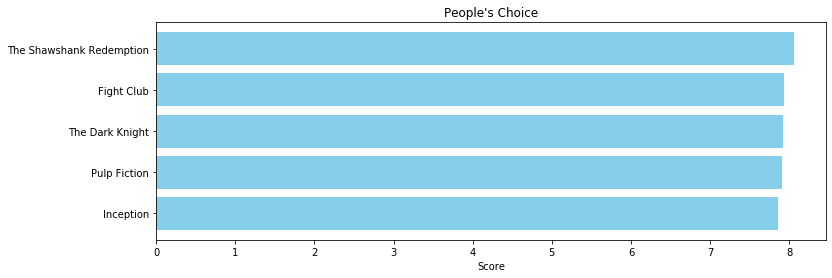

In [0]:
plt.figure(figsize=(12,4))

plt.barh(rated_movie['title_y'].head(5),rated_movie['score'].head(5), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Score")
plt.title("People's Choice")

# Content Based Filtering

The next type of filtering that we can utilize is content based filtering. 

In [0]:
movies['overview'].head()

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

In [0]:
movies.isnull().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title_x                    0
vote_average               0
vote_count                 0
title_y                    0
cast                       0
crew                       0
dtype: int64

In [0]:
movies['overview'].fillna('',inplace=True)

In [0]:
vectorizer = TfidfVectorizer(stop_words='english')
vec_matrix = vectorizer.fit_transform(movies['overview'])
print(vec_matrix.shape)

(4803, 20978)


In [0]:
cos_similar = linear_kernel(vec_matrix,vec_matrix)

In [0]:
indices = pd.Series(movies.index, index=movies['title_x']).drop_duplicates()

In [0]:
def recommendations(title,similarity=cos_similar):
    idx = indices[title]
    sim = list(enumerate(similarity[idx]))
    sim = sorted(sim, key=lambda x: x[1], reverse=True)
    sim = sim[1:11]
    movie_indices = [i[0] for i in sim]
    return movies['title_x'].iloc[movie_indices]


In [0]:
recommendations('Iron Man')

79                     Iron Man 2
31                     Iron Man 3
1868           Cradle 2 the Grave
7         Avengers: Age of Ultron
538                       Hostage
119                 Batman Begins
1290     Baahubali: The Beginning
4574                     Roadside
2044           The Little Vampire
2633    The Clan of the Cave Bear
Name: title_x, dtype: object

In order to make the content based recommender more robust we will add more parameters into it.

In [0]:
movies['cast'][0]

In [0]:
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    movies[feature] = movies[feature].apply(literal_eval)

In [0]:
movies.head()

budget  ...                                               crew
0  237000000  ...  [{'credit_id': '52fe48009251416c750aca23', 'de...
1  300000000  ...  [{'credit_id': '52fe4232c3a36847f800b579', 'de...
2  245000000  ...  [{'credit_id': '54805967c3a36829b5002c41', 'de...
3  250000000  ...  [{'credit_id': '52fe4781c3a36847f81398c3', 'de...
4  260000000  ...  [{'credit_id': '52fe479ac3a36847f813eaa3', 'de...

[5 rows x 23 columns]

In [0]:
def director(x):
    for i in x:
        if i['job']=='Director':
            return i['name']
    return np.nan

In [0]:
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [0]:
# Define new director, cast, genres and keywords features that are in a suitable form.
movies['director'] = movies['crew'].apply(director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    movies[feature] = movies[feature].apply(get_list)

In [0]:
movies.head()

budget  ...           director
0  237000000  ...      James Cameron
1  300000000  ...     Gore Verbinski
2  245000000  ...         Sam Mendes
3  250000000  ...  Christopher Nolan
4  260000000  ...     Andrew Stanton

[5 rows x 24 columns]

In [0]:
movies['production_companies']=movies['production_companies'].apply(literal_eval).apply(get_list)

In [0]:
movies.head()

budget  ...           director
0  237000000  ...      James Cameron
1  300000000  ...     Gore Verbinski
2  245000000  ...         Sam Mendes
3  250000000  ...  Christopher Nolan
4  260000000  ...     Andrew Stanton

[5 rows x 24 columns]

In [0]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [0]:
features = ['cast', 'keywords', 'director', 'genres','overview','production_companies']

for feature in features:
    movies[feature] = movies[feature].apply(clean_data)

In [0]:
def combination(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])+' '+' '.join(x['production_companies'])
movies['combined'] = movies.apply(combination, axis=1)

In [0]:
movies.head()

budget  ...                                           combined
0  237000000  ...  cultureclash future spacewar samworthington zo...
1  300000000  ...  ocean drugabuse exoticisland johnnydepp orland...
2  245000000  ...  spy basedonnovel secretagent danielcraig chris...
3  250000000  ...  dccomics crimefighter terrorist christianbale ...
4  260000000  ...  basedonnovel mars medallion taylorkitsch lynnc...

[5 rows x 25 columns]

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

count_vec = CountVectorizer(stop_words='english')
count_vec_matrix = count_vec.fit_transform(movies['combined'])

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

cos_similar2 = cosine_similarity(count_vec_matrix, count_vec_matrix)

In [0]:
movies = movies.reset_index()
indices = pd.Series(movies.index, index=movies['title_x'])

In [0]:
recommendations('The Dark Knight Rises',cos_similar2)

65               The Dark Knight
119                Batman Begins
14                  Man of Steel
1196                The Prestige
4638    Amidst the Devil's Wings
10              Superman Returns
1035                   Jonah Hex
299               Batman Forever
303                     Catwoman
747               Gangster Squad
Name: title_x, dtype: object

# Colaborative Filtering

Since the initial dataset didnt had any userID information, so we will use a different dataset to build the recommender system on colaborative filter

In [0]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
r=Reader()

In [0]:
ratings = pd.read_csv('/content/ratings_small.csv')

In [0]:
ratings.head()

userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205

In [0]:
data = Dataset.load_from_df(ratings[['userId','movieId','rating']],r)

In [0]:
algo=SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9106  0.8864  0.8951  0.8988  0.8946  0.8971  0.0079  
MAE (testset)     0.6985  0.6830  0.6881  0.6903  0.6914  0.6903  0.0050  
Fit time          4.49    4.51    4.60    4.47    4.45    4.50    0.05    
Test time         0.13    0.25    0.14    0.13    0.23    0.18    0.05    


{'fit_time': (4.486847877502441,
  4.511595726013184,
  4.603022336959839,
  4.46574592590332,
  4.451321125030518),
 'test_mae': array([0.69846322, 0.6829812 , 0.68809451, 0.69034755, 0.69140326]),
 'test_rmse': array([0.91057422, 0.88642714, 0.89508384, 0.89881724, 0.89456965]),
 'test_time': (0.1315441131591797,
  0.2519216537475586,
  0.13776731491088867,
  0.12950825691223145,
  0.22987771034240723)}

In [0]:
trainset = data.build_full_trainset()
algo.fit(trainset)

In [0]:
ratings[ratings['userId'] == 1]

userId  movieId  rating   timestamp
0        1       31     2.5  1260759144
1        1     1029     3.0  1260759179
2        1     1061     3.0  1260759182
3        1     1129     2.0  1260759185
4        1     1172     4.0  1260759205
5        1     1263     2.0  1260759151
6        1     1287     2.0  1260759187
7        1     1293     2.0  1260759148
8        1     1339     3.5  1260759125
9        1     1343     2.0  1260759131
10       1     1371     2.5  1260759135
11       1     1405     1.0  1260759203
12       1     1953     4.0  1260759191
13       1     2105     4.0  1260759139
14       1     2150     3.0  1260759194
15       1     2193     2.0  1260759198
16       1     2294     2.0  1260759108
17       1     2455     2.5  1260759113
18       1     2968     1.0  1260759200
19       1     3671     3.0  1260759117

In [0]:
algo.predict(1, 302,3,True)

Prediction(uid=1, iid=302, r_ui=3, est=2.7744162532359495, details={'was_impossible': False})

# Deep Neural Network

In [0]:
df = pd.read_csv('/content/u.data',sep='\t',names="user_id,item_id,rating,timestamp".split(","))


In [0]:
df.head()
df['user_id'] = df['user_id'].astype('category').cat.codes.values
df['item_id'] = df['item_id'].astype('category').cat.codes.values

In [0]:
df.head()

user_id  item_id  rating  timestamp
0      195      241       3  881250949
1      185      301       3  891717742
2       21      376       1  878887116
3      243       50       2  880606923
4      165      345       1  886397596

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)

In [0]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
n_users, n_movies = len(df.user_id.unique()), len(df.item_id.unique())
n_latent_factors = 3

In [0]:
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))

# prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
prod = keras.layers.dot([movie_vec, user_vec], axes=1, normalize=False)
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         5049        Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         2832        User[0][0]                       
____________________________________________________________________________________________

In [0]:
test.head()

user_id  item_id  rating  timestamp
82076      850      265       3  886534672
30616      404      555       1  885546636
45838      544      742       3  879901322
58232      302      229       3  879483511
42565       17       22       4  880130065

In [0]:
test.shape,train.shape

((20000, 4), (80000, 4))

In [0]:
dev,test1=train_test_split(test,test_size=0.5)

In [0]:
dev.shape,test1.shape

((10000, 4), (10000, 4))

In [0]:
history = model.fit([train.user_id, train.item_id], train.rating, batch_size=1024,
                    validation_data=([dev.user_id,dev.item_id],dev.rating),
                    epochs=100, verbose=1)

Train on 80000 samples, validate on 10000 samples
Epoch 1/100
80000/80000 [==============================] - 0s 4us/step - loss: 0.8127 - val_loss: 0.8967
Epoch 2/100
80000/80000 [==============================] - 0s 3us/step - loss: 0.8119 - val_loss: 0.8958
Epoch 3/100
80000/80000 [==============================] - 0s 3us/step - loss: 0.8112 - val_loss: 0.8951
Epoch 4/100
80000/80000 [==============================] - 0s 4us/step - loss: 0.8105 - val_loss: 0.8946
Epoch 5/100
80000/80000 [==============================] - 0s 3us/step - loss: 0.8099 - val_loss: 0.8940
Epoch 6/100
80000/80000 [==============================] - 0s 3us/step - loss: 0.8094 - val_loss: 0.8936
Epoch 7/100
80000/80000 [==============================] - 0s 4us/step - loss: 0.8089 - val_loss: 0.8932
Epoch 8/100
80000/80000 [==============================] - 0s 4us/step - loss: 0.8084 - val_loss: 0.8930
Epoch 9/100
80000/80000 [==============================] - 0s 4us/step - loss: 0.8080 - val_loss: 0.8928
Epoch

In [0]:
from sklearn.metrics import mean_absolute_error as mae
ans = mae(test1.rating,model.predict([test1.user_id,test1.item_id]))

In [0]:
print(ans)

0.731275659687724


In [0]:
from keras.constraints import non_neg
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='NonNegMovie-Embedding', embeddings_constraint=non_neg())(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='NonNegUser-Embedding',embeddings_constraint=non_neg())(user_input))

#prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
prod = keras.layers.dot([movie_vec, user_vec], axes=1, normalize=False)
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

In [0]:
history = model.fit([train.user_id, train.item_id], train.rating, batch_size=1024,
                    validation_data=([dev.user_id,dev.item_id],dev.rating),
                    epochs=100, verbose=1)

Train on 80000 samples, validate on 10000 samples
Epoch 1/100
80000/80000 [==============================] - 0s 6us/step - loss: 13.7095 - val_loss: 13.4539
Epoch 2/100
80000/80000 [==============================] - 0s 4us/step - loss: 13.4334 - val_loss: 13.0065
Epoch 3/100
80000/80000 [==============================] - 0s 4us/step - loss: 12.8053 - val_loss: 12.2169
Epoch 4/100
80000/80000 [==============================] - 0s 4us/step - loss: 11.8577 - val_loss: 11.1515
Epoch 5/100
80000/80000 [==============================] - 0s 4us/step - loss: 10.6718 - val_loss: 9.8989
Epoch 6/100
80000/80000 [==============================] - 0s 3us/step - loss: 9.3401 - val_loss: 8.5521
Epoch 7/100
80000/80000 [==============================] - 0s 4us/step - loss: 7.9596 - val_loss: 7.2054
Epoch 8/100
80000/80000 [==============================] - 0s 4us/step - loss: 6.6193 - val_loss: 5.9363
Epoch 9/100
80000/80000 [==============================] - 0s 3us/step - loss: 5.3917 - val_loss: 4.8

In [0]:
from sklearn.metrics import mean_absolute_error as mae
ans1 = mae(test1.rating,model.predict([test1.user_id,test1.item_id]))
print(ans1)

0.7509986679261085


In [0]:
n_latent_factors_user = 5
n_latent_factors_movie = 8

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.2)(movie_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.2)(user_vec)


# concat = keras.layers.merge([movie_vec, user_vec], mode='concat',name='Concat')
concat = keras.layers.concatenate([movie_vec, user_vec],axis=1)
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
# adam = Adam(lr=0.005)
model = keras.Model([user_input, movie_input], result)
model.compile(optimizer='adam',loss= 'mean_squared_error')

In [0]:
history = model.fit([train.user_id, train.item_id], train.rating, batch_size=1024,
                    validation_data=([dev.user_id,dev.item_id],dev.rating),
                    epochs=100, verbose=1)

Train on 80000 samples, validate on 10000 samples
Epoch 1/100
80000/80000 [==============================] - 1s 12us/step - loss: 3.9620 - val_loss: 1.0215
Epoch 2/100
80000/80000 [==============================] - 0s 5us/step - loss: 0.9647 - val_loss: 0.9013
Epoch 3/100
80000/80000 [==============================] - 0s 6us/step - loss: 0.9086 - val_loss: 0.8901
Epoch 4/100
80000/80000 [==============================] - 0s 4us/step - loss: 0.8924 - val_loss: 0.8868
Epoch 5/100
80000/80000 [==============================] - 0s 5us/step - loss: 0.8844 - val_loss: 0.8853
Epoch 6/100
80000/80000 [==============================] - 0s 5us/step - loss: 0.8805 - val_loss: 0.8828
Epoch 7/100
80000/80000 [==============================] - 0s 5us/step - loss: 0.8750 - val_loss: 0.8840
Epoch 8/100
80000/80000 [==============================] - 0s 5us/step - loss: 0.8739 - val_loss: 0.8835
Epoch 9/100
80000/80000 [==============================] - 0s 5us/step - loss: 0.8707 - val_loss: 0.8839
Epoc

In [0]:
from sklearn.metrics import mean_absolute_error as mae
ans2 = mae(test1.rating,model.predict([test1.user_id,test1.item_id]))
print(ans2)

0.7306314009994268
